In [1]:
import numpy as np

In [2]:
def load_labels(path):
    with open(path, "r") as f:
        all_preds = f.readlines()
    preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
    return np.array(preds_processed)

Load label names

In [3]:
with open("test_labels.txt", "r") as f:
    label_names = f.readlines()[0].split(" ")

In [4]:
label_names

['Drama',
 'Film-Noir',
 'Mystery',
 'Thriller',
 'Adventure',
 'Crime',
 'Horror',
 'Romance',
 'Sport',
 'Fantasy',
 'Biography',
 'Action',
 'Music',
 'War',
 'Documentary',
 'Short',
 'Animation',
 'Comedy',
 'Family',
 'Musical',
 'Sci-Fi',
 'Western',
 'History']

In [5]:
label2idx = dict([(name, i) for i, name in enumerate(label_names)])

Load test gold predictions

In [6]:
gold_preds = load_labels("model_save_vilbert/vilbert_model_run/test_labels_gold.txt")
print(f"Preds shape: {gold_preds.shape}")

Preds shape: (7799, 23)


Count total predictions by label

In [7]:
import collections

preds_unfold = []
for pred in gold_preds:
    preds_unfold.extend(list(np.where(pred == 1)[0]))
    
counts = collections.Counter(preds_unfold)
sorted(counts.items())

[(0, 4142),
 (1, 102),
 (2, 617),
 (3, 1567),
 (4, 821),
 (5, 1163),
 (6, 825),
 (7, 1590),
 (8, 191),
 (9, 585),
 (10, 411),
 (11, 1044),
 (12, 311),
 (13, 401),
 (14, 629),
 (15, 142),
 (16, 306),
 (17, 2611),
 (18, 518),
 (19, 253),
 (20, 586),
 (21, 210),
 (22, 345)]

Get indexes of examples wehre prediction should be made by label

indexesByLabel[0] -> Indexes of gold_preds where prediction should be made for class 0 <br>
indexesByLabel[1] -> Indexes of gold_preds where prediction should be made for class 1 <br>
...

In [9]:
indexesByLabel = []
for i in range(23):
    exampleIndexes = []
    for idx, pred in enumerate(gold_preds):
        if pred[i] == 1:
            exampleIndexes.append(idx)
    indexesByLabel.append(exampleIndexes)

Load test predictions

In [10]:
vilbert_preds = load_labels("model_save_vilbert/vilbert_model_run/test_labels_pred.txt")
print(f"ViLBERT preds shape: {vilbert_preds.shape}")

mmbt_preds = load_labels("model_save_mmbt/mmbt_model_run/test_labels_pred.txt")
print(f"MMBT preds shape: {mmbt_preds.shape}")

mmtr_preds = load_labels("model_save_mmtr/mmtr_model_run/test_labels_pred.txt")
print(f"MMTR preds shape: {mmtr_preds.shape}")

mmtrbig_preds = load_labels("model_save_mmtrBig/mmtrBig_model_run/test_labels_pred.txt")
print(f"MMTRBig preds shape: {mmtrbig_preds.shape}")

ViLBERT preds shape: (7799, 23)
MMBT preds shape: (7799, 23)
MMTR preds shape: (7799, 23)
MMTRBig preds shape: (7799, 23)


Process counts of correct predictions for each label (0, 1, 2, ..., 22)

In [28]:
import pandas as pd
from sklearn.metrics import f1_score

def freqs_dataframe(data_preds, model_name, label_names):
    countsLabel = []
    
    scores = f1_score(gold_preds, data_preds, average=None)
    '''
    for class_id, idxsList in enumerate(indexesByLabel):
        count = 0
        for idx in idxsList:
            if data_preds[idx][class_id] == 1:
                count += 1
        countsLabel.append(count/len(idxsList))
    '''
        
    df = pd.DataFrame()
    df['label'] = label_names
    df['freq'] = list(scores)
    df['model'] = [model_name]*len(label_names)
            
    return df

In [14]:
vilbert_freqs = freqs_dataframe(vilbert_preds, "vilbert", label_names)
mmbt_freqs = freqs_dataframe(mmbt_preds, "mmbt", label_names)
mmtr_freqs = freqs_dataframe(mmtr_preds, "mmtr", label_names)
mmtrbig_freqs = freqs_dataframe(mmtrbig_preds, "mmtr", label_names)
all_models_freqs = pd.concat([vilbert_freqs, mmbt_freqs, mmtrbig_freqs])

Plot and compare accuracy per label (movie genre) of all models

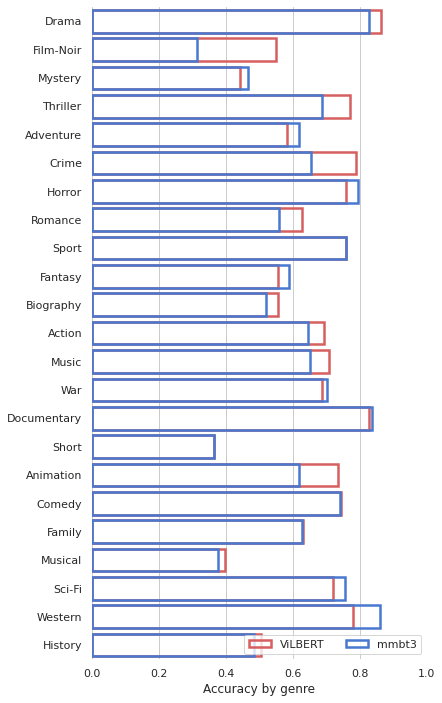

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 12))


sns.set_color_codes("muted")

sns.barplot(x="freq", y="label", data=vilbert_freqs,
            label="ViLBERT", edgecolor="r", facecolor=(1, 1, 1, 0), linewidth=2.5)

ax_bar = sns.barplot(x="freq", y="label", data=mmbt3_freqs,
            label="mmbt3", edgecolor="b", facecolor=(1, 1, 1, 0), linewidth=2.5)

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1), ylabel="",
       xlabel="Accuracy by genre")
sns.despine(left=True, bottom=True)

Ordered classses by training frequency from highest to lowest

In [40]:
ordered_classes = ['Drama',
                 'Comedy',
                 'Romance',
                 'Thriller',
                 'Crime',
                 'Action',
                 'Adventure',
                 'Horror',
                 'Documentary',
                 'Mystery',
                 'Sci-Fi',
                 'Fantasy',
                 'Family',
                 'War',
                 'Biography',
                 'History',
                 'Music',
                 'Animation',
                 'Musical',
                 'Western',
                 'Sport',
                 'Short',
                 'Film-Noir']

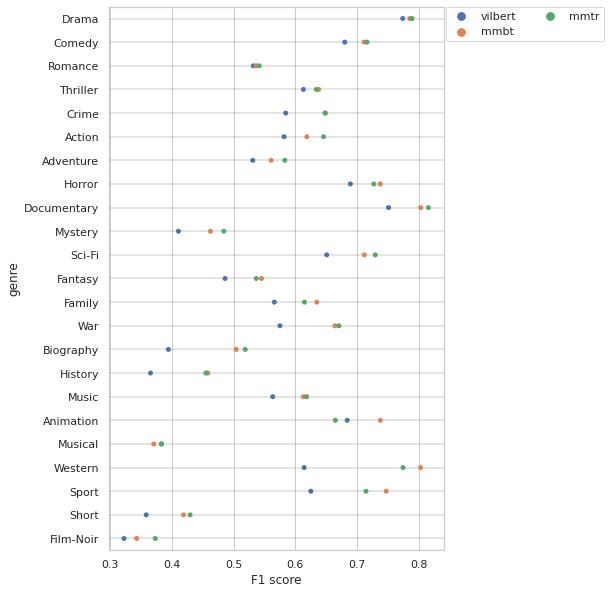

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 10))
ax_points = sns.stripplot(x="freq", y="label", data=all_models_freqs, hue="model", jitter=0, order=ordered_classes)
ax.legend(ncol=2, loc="upper left", frameon=True, bbox_to_anchor=(0.99, 1.01))
ax.set(xlabel="F1 score", ylabel="genre")

for i in range(len(label_names)):
    ax_points.axhline(i, color='black', alpha=0.1, lw = 2)

Plot correct predictions of each example by label (movie genre)

In [19]:
def pred_class_dataframe(data_preds_list, label_id):
    binary_preds = []
    ids = []
    model_name = []
    origin_ids = []

    for name, data_preds in data_preds_list.items():
        for i, idx in enumerate(indexesByLabel[label_id]):
            binary_preds.append(1 if data_preds[idx][label_id] == gold_preds[idx][label_id] else 0)
            ids.append(i)
            model_name.append(name)
            origin_ids.append(idx)
    
    df = pd.DataFrame()
    df['result'] = binary_preds
    df['id'] = ids
    df['model'] = model_name
    df['origin_id'] = origin_ids
            
    return df

In [26]:
preds_all_models = {'vilbert': vilbert_preds,
                    'mmbt': mmbt_preds,
                    'mmtrBig': mmtrbig_preds}

results_model = pred_class_dataframe(preds_all_models, label2idx['Film-Noir'])

In [27]:
results_model

,result,id,model,origin_id
0,0,0,vilbert,0
1,0,1,vilbert,1
2,1,2,vilbert,2
3,1,3,vilbert,3
4,0,4,vilbert,4
...,...,...,...,...
301,0,97,mmtrBig,97
302,0,98,mmtrBig,98
303,0,99,mmtrBig,99
304,0,100,mmtrBig,100


In [ ]:
f, ax = plt.subplots(figsize=(6, 10))
sns.stripplot(x="id", y="result", data=results_model, hue="model", jitter=0)
ax.legend(ncol=2, loc="lower right", frameon=True)

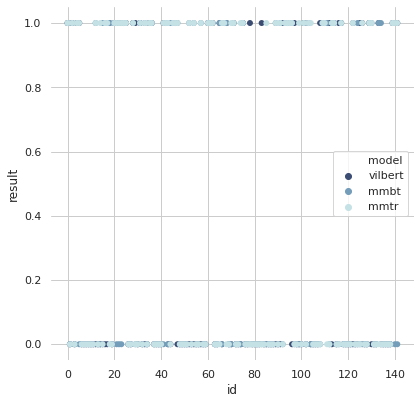

In [255]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x="id", y="result",
                hue="model",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 1), linewidth=0,
                data=results_model, ax=ax)

Get test dataset idexes for a specific label where all models' predictions are incorrect

In [25]:
def pred_class_dataframe_ids(data_preds, label_id):
    binary_preds = []
    origin_ids = []

    for i, idx in enumerate(indexesByLabel[label_id]):
        binary_preds.append(1 if data_preds[idx][label_id] == gold_preds[idx][label_id] else 0)
        origin_ids.append(idx)
    
    df = pd.DataFrame()
    df['result'] = binary_preds
    df['origin_id'] = origin_ids
            
    return df

In [60]:
target_label = 'Film-Noir'

vilbert_results_model_ids = pred_class_dataframe_ids(vilbert_preds, label2idx[target_label])
mmbt_results_model_ids = pred_class_dataframe_ids(mmbt_preds, label2idx[target_label])
mmtrbig_results_model_ids = pred_class_dataframe_ids(mmtrbig_preds, label2idx[target_label])

In [61]:
incorrect_pred = vilbert_results_model_ids['result'] == 0
vilbert_incorrect = vilbert_results_model_ids[incorrect_pred]

incorrect_pred = mmbt_results_model_ids['result'] == 0
mmbt_incorrect = mmbt_results_model_ids[incorrect_pred]

incorrect_pred = mmtrbig_results_model_ids['result'] == 0
mmtr_incorrect = mmtrbig_results_model_ids[incorrect_pred]

In [62]:
temp_merge = pd.merge(vilbert_incorrect, mmbt_incorrect, how='inner', on=['origin_id'])
all_incorrect_preds = pd.merge(mmtr_incorrect, temp_merge, how='inner', on=['origin_id'])['origin_id']
all_incorrect_preds

0       1
1       5
2       7
3       8
4      12
5      14
6      21
7      24
8      26
9      33
10     34
11     38
12     39
13     41
14     47
15     51
16     52
17     57
18     65
19     72
20     74
21     75
22     82
23     92
24     93
25     95
26     97
27     99
28    100
29    101
Name: origin_id, dtype: int64

### Explore incorrect predictions

Get all indexes of predicted examples that were incorrect

In [32]:
all_incorrect_preds = list(all_incorrect_preds)

Get all test set examples

In [36]:
import json

data = [json.loads(l) for l in open('/home/est_posgrado_isaac.bribiesca/mmimdb/test.jsonl')]

Filter the incorrect test examples in all models

In [39]:
data_filtered = [data[i] for i in all_incorrect_preds]

Keep only the genres

In [41]:
genres = [row['label'] for row in data_filtered]

In [42]:
genres

[['Drama', 'Film-Noir'],
 ['Drama', 'Film-Noir', 'Mystery', 'Romance', 'Thriller'],
 ['Crime', 'Drama', 'Film-Noir', 'Romance'],
 ['Crime', 'Drama', 'Film-Noir', 'Thriller'],
 ['Crime', 'Drama', 'Film-Noir'],
 ['Drama', 'Film-Noir', 'Thriller'],
 ['Crime', 'Film-Noir', 'Thriller'],
 ['Biography', 'Crime', 'Drama', 'Film-Noir'],
 ['Drama', 'Film-Noir'],
 ['Drama', 'Film-Noir'],
 ['Adventure', 'Drama', 'Film-Noir', 'War'],
 ['Crime', 'Drama', 'Film-Noir', 'Thriller'],
 ['Crime', 'Film-Noir', 'Thriller'],
 ['Crime', 'Film-Noir', 'Mystery', 'Thriller'],
 ['Crime', 'Drama', 'Film-Noir'],
 ['Crime', 'Drama', 'Film-Noir'],
 ['Crime', 'Drama', 'Film-Noir', 'Thriller'],
 ['Thriller', 'Film-Noir', 'Drama'],
 ['Crime', 'Drama', 'Film-Noir', 'Thriller'],
 ['Crime', 'Drama', 'Film-Noir', 'Thriller'],
 ['Drama', 'Film-Noir', 'Sport', 'Thriller'],
 ['Drama', 'Film-Noir', 'Thriller'],
 ['Crime', 'Film-Noir', 'Thriller'],
 ['Drama', 'Film-Noir', 'Thriller'],
 ['Crime', 'Drama', 'Film-Noir', 'Thriller']

Get genre names predicted by model in the incorrect examples

In [53]:
mmbt_incorrect_intersection = [mmbt_preds[i] for i in all_incorrect_preds]
mmbt_incorrect_label_names = [[label_names[i] for i in np.where(row == 1)[0]] for row in mmbt_incorrect_intersection]

In [54]:
mmbt_incorrect_label_names

[['Drama', 'Comedy'],
 ['Drama', 'Comedy'],
 ['Drama', 'Crime', 'Comedy'],
 ['Drama', 'Crime', 'Action', 'Comedy'],
 ['Drama', 'Crime', 'Action'],
 ['Mystery', 'Thriller', 'Crime', 'Horror'],
 ['Drama', 'Mystery', 'Thriller', 'Crime'],
 ['Drama', 'Crime'],
 ['Drama', 'Romance', 'Comedy'],
 ['Drama', 'Romance'],
 ['Drama', 'Adventure', 'War'],
 ['Drama', 'Thriller', 'Action'],
 ['Crime', 'Romance', 'Comedy'],
 ['Thriller', 'Horror', 'Comedy'],
 ['Drama', 'Romance'],
 ['Drama', 'War'],
 ['Drama', 'Thriller', 'Crime', 'Action'],
 ['Drama', 'Thriller', 'Horror', 'War'],
 ['Drama', 'Thriller', 'Crime'],
 ['Drama', 'Romance', 'Biography'],
 ['Drama', 'Crime', 'Sport', 'Biography'],
 ['Drama', 'Romance'],
 ['Drama', 'Thriller', 'Crime', 'Comedy'],
 ['Drama', 'Mystery', 'Horror'],
 ['Drama', 'Crime'],
 ['Drama', 'Mystery', 'Thriller', 'Romance'],
 ['Drama', 'Romance', 'Comedy'],
 ['Drama', 'Thriller', 'Crime'],
 ['Drama', 'Thriller', 'Romance'],
 ['Drama', 'Crime']]

Compare true vs pred genres in incorrect predictions

In [58]:
print("true - pred")
for gold, pred in zip(genres, mmbt_incorrect_label_names):
    print(f'{gold} - {pred}')

true - pred
['Drama', 'Film-Noir'] - ['Drama', 'Comedy']
['Drama', 'Film-Noir', 'Mystery', 'Romance', 'Thriller'] - ['Drama', 'Comedy']
['Crime', 'Drama', 'Film-Noir', 'Romance'] - ['Drama', 'Crime', 'Comedy']
['Crime', 'Drama', 'Film-Noir', 'Thriller'] - ['Drama', 'Crime', 'Action', 'Comedy']
['Crime', 'Drama', 'Film-Noir'] - ['Drama', 'Crime', 'Action']
['Drama', 'Film-Noir', 'Thriller'] - ['Mystery', 'Thriller', 'Crime', 'Horror']
['Crime', 'Film-Noir', 'Thriller'] - ['Drama', 'Mystery', 'Thriller', 'Crime']
['Biography', 'Crime', 'Drama', 'Film-Noir'] - ['Drama', 'Crime']
['Drama', 'Film-Noir'] - ['Drama', 'Romance', 'Comedy']
['Drama', 'Film-Noir'] - ['Drama', 'Romance']
['Adventure', 'Drama', 'Film-Noir', 'War'] - ['Drama', 'Adventure', 'War']
['Crime', 'Drama', 'Film-Noir', 'Thriller'] - ['Drama', 'Thriller', 'Action']
['Crime', 'Film-Noir', 'Thriller'] - ['Crime', 'Romance', 'Comedy']
['Crime', 'Film-Noir', 'Mystery', 'Thriller'] - ['Thriller', 'Horror', 'Comedy']
['Crime', 'Dr

In [67]:
print("Missing labels:\n")
for gold, pred in zip(genres, mmbt_incorrect_label_names):
    missing = set(gold).difference(set(pred))
    #missing.remove(target_label)
    print(missing)

Missing labels:

{'Film-Noir'}
{'Romance', 'Film-Noir', 'Thriller', 'Mystery'}
{'Romance', 'Film-Noir'}
{'Film-Noir', 'Thriller'}
{'Film-Noir'}
{'Film-Noir', 'Drama'}
{'Film-Noir'}
{'Biography', 'Film-Noir'}
{'Film-Noir'}
{'Film-Noir'}
{'Film-Noir'}
{'Film-Noir', 'Crime'}
{'Film-Noir', 'Thriller'}
{'Film-Noir', 'Crime', 'Mystery'}
{'Film-Noir', 'Crime'}
{'Film-Noir', 'Crime'}
{'Film-Noir'}
{'Film-Noir'}
{'Film-Noir'}
{'Film-Noir', 'Crime', 'Thriller'}
{'Film-Noir', 'Thriller'}
{'Film-Noir', 'Thriller'}
{'Film-Noir'}
{'Film-Noir', 'Thriller'}
{'Film-Noir', 'Thriller'}
{'Film-Noir'}
{'Film-Noir'}
{'Film-Noir'}
{'Film-Noir'}
{'Film-Noir', 'Thriller'}


In [66]:
print("Incorrect labels:\n")
for gold, pred in zip(genres, mmbt_incorrect_label_names):
    missing = set(pred).difference(set(gold))
    #missing.remove(target_label)
    print(missing)

Incorrect labels:

{'Comedy'}
{'Comedy'}
{'Comedy'}
{'Action', 'Comedy'}
{'Action'}
{'Horror', 'Crime', 'Mystery'}
{'Drama', 'Mystery'}
set()
{'Romance', 'Comedy'}
{'Romance'}
set()
{'Action'}
{'Romance', 'Comedy'}
{'Horror', 'Comedy'}
{'Romance'}
{'War'}
{'Action'}
{'Horror', 'War'}
set()
{'Romance', 'Biography'}
{'Biography', 'Crime'}
{'Romance'}
{'Comedy', 'Drama'}
{'Horror', 'Mystery'}
set()
{'Thriller', 'Mystery'}
{'Comedy'}
{'Thriller'}
{'Romance'}
{'Drama'}


### GMU gates visualization

In [300]:
gates = np.load('model_save_mmtrgmu/mmtrgmu_model_run/gates.npy')

In [301]:
gates_rounded = gates.round()

In [306]:
gates_freqs = np.sum(gates_rounded, axis=1)

In [309]:
gates_freqs = gates_freqs/30

In [310]:
gates_freqs

array([0.6333333 , 0.56666666, 0.53333336, ..., 0.6666667 , 0.6333333 ,
       0.53333336], dtype=float32)

In [312]:
np.mean(gates, axis=1)

array([0.5582661 , 0.56419015, 0.49996036, ..., 0.5745738 , 0.5874417 ,
       0.53913426], dtype=float32)

### Training and Validation loss

In [114]:
def get_loss(path):
    
    with open(path, "r") as f:
        log = f.readlines()
        
    start_index = [i for i, s in enumerate(log) if "Training.." in s][0]
    log_metrics = log[start_index+1:]
    
    train_loss = [s.split("-")[-1].split(":")[-1].strip().strip("\n") for s in log_metrics if "Train" in s]
    train_loss = np.array([float(v) for v in train_loss])
    
    val_loss = [s.split("-")[-1].split("|")[0].split(":")[-1].strip().strip("\n") for s in log_metrics if "Val" in s]
    val_loss = np.array([float(v) for v in val_loss])
    
    return train_loss, val_loss

Graph loss vs epoch MMBT

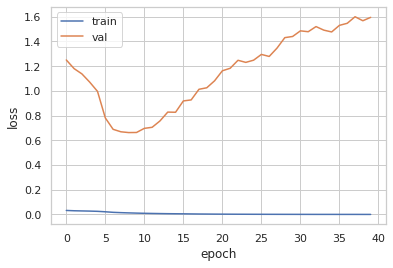

In [115]:
train_loss, val_loss = get_loss("model_save_mmbt/mmbt_model_run/logfile.log")

plt.subplot(111)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

Graph loss vs epoch MMTRBig

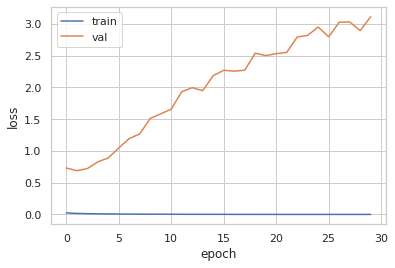

In [116]:
train_loss, val_loss = get_loss("model_save_mmtrBig/mmtrBig_model_run/logfile.log")

plt.subplot(111)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

Graph loss vs epoch ViLBERT

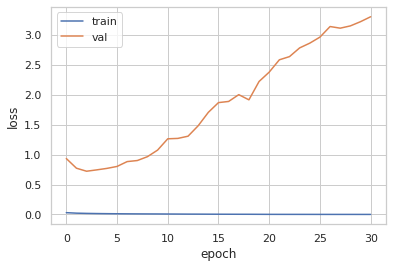

In [117]:
train_loss, val_loss = get_loss("model_save_vilbert/vilbert_model_run/logfile.txt")

plt.subplot(111)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

### Validation accuracy

In [136]:
def get_f1(path):
    
    with open(path, "r") as f:
        log = f.readlines()
        
    start_index = [i for i, s in enumerate(log) if "Training.." in s][0]
    log_metrics = log[start_index+1:]
    
    micro = [s.split("-")[-1].split("|")[2][11:].strip().strip("\n") for s in log_metrics if "Val" in s]
    micro = np.array([float(v) for v in micro])
    
    macro = [s.split("-")[-1].split("|")[1][9:].strip().strip("\n") for s in log_metrics if "Val" in s]
    macro = np.array([float(v) for v in macro])
    
    return micro, macro

Validation F1 scores MMBT

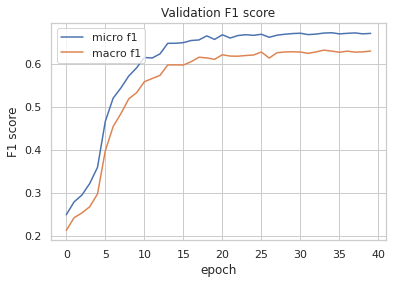

In [153]:
micro_test, macro_test = get_f1("model_save_mmbt/mmbt_model_run/logfile.log")

plt.subplot(111)
plt.plot(micro_test, label='micro f1')
plt.plot(macro_test, label='macro f1')
plt.xlabel('epoch')
plt.ylabel('F1 score')
plt.legend(loc='upper left')
plt.title("Validation F1 score")
plt.show()

Validation F1 scores MMTRBig

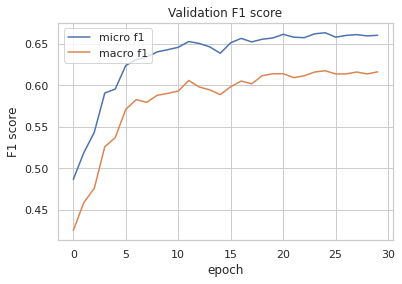

In [154]:
micro_test, macro_test = get_f1("model_save_mmtrBig/mmtrBig_model_run/logfile.log")

plt.subplot(111)
plt.plot(micro_test, label='micro f1')
plt.plot(macro_test, label='macro f1')
plt.xlabel('epoch')
plt.ylabel('F1 score')
plt.legend(loc='upper left')
plt.title("Validation F1 score")
plt.show()

Validation F1 scores ViLBERT

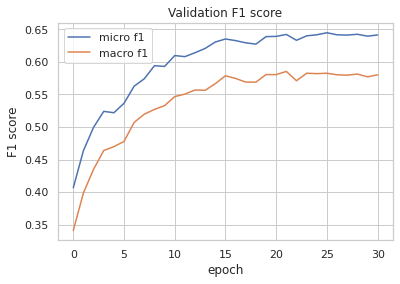

In [152]:
micro_test, macro_test = get_f1("model_save_vilbert/vilbert_model_run/logfile.txt")

plt.subplot(111)
plt.plot(micro_test, label='micro f1')
plt.plot(macro_test, label='macro f1')
plt.xlabel('epoch')
plt.ylabel('F1 score')
plt.legend(loc='upper left')
plt.title("Validation F1 score")
plt.show()

### Visualize raw predicitons

In [3]:
import numpy as np

In [30]:
raw_preds = np.load('model_save_mmbt/mmbt_model_run/preds_raw.npy')
max_pred_indexes = np.argmax(raw_preds, axis=1)
max_pred_category = [label_names[i] for i in max_pred_indexes]
gold_pred_max = gold_preds[:, :]

In [33]:
pred_max = np.zeros(raw_preds.shape)

for i in range(pred_max.shape[0]):
    pred_max[i][max_pred_indexes[i]] = 1
    
    for j in range(pred_max.shape[1]):
        if j != max_pred_indexes[i]:
            gold_pred_max[i][j] = 0

In [41]:
import pandas as pd
from sklearn.metrics import f1_score

def freqs_dataframe_max(data_preds, model_name, label_names):
    countsLabel = []
    
    scores = f1_score(gold_pred_max, data_preds, average=None)
        
    df = pd.DataFrame()
    df['label'] = label_names
    df['freq'] = list(scores)
    df['model'] = [model_name]*len(label_names)
            
    return df

In [42]:
mmbt_freqs_max = freqs_dataframe_max(pred_max, "mmbt", label_names)

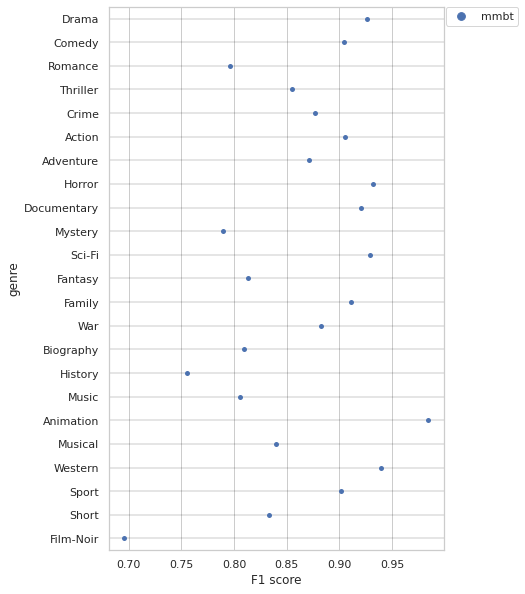

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 10))
ax_points = sns.stripplot(x="freq", y="label", data=mmbt_freqs_max, hue="model", jitter=0, order=ordered_classes)
ax.legend(ncol=2, loc="upper left", frameon=True, bbox_to_anchor=(0.99, 1.01))
ax.set(xlabel="F1 score", ylabel="genre")

for i in range(len(label_names)):
    ax_points.axhline(i, color='black', alpha=0.1, lw = 2)

### Complementarity

Compare argmax classes between models

In [8]:
raw_preds_img = np.load('model_save_mmtrBig/mmtrImg_model_run/preds_raw.npy')
raw_preds_txt = np.load('model_save_mmtrBig/mmtrTxt_model_run/preds_raw.npy')

In [9]:
max_pred_indexes_img = np.argmax(raw_preds_img, axis=1)
max_pred_indexes_txt = np.argmax(raw_preds_txt, axis=1)

In [10]:
diff = np.sum(max_pred_indexes_img != max_pred_indexes_txt)

In [11]:
print(diff/max_pred_indexes_img.shape[0])

0.2687524041543788


Maximum Possible Accuracy

Combining MMTr Text and Image models

In [29]:
mpa_pred = np.maximum(raw_preds_img, raw_preds_txt)
mpa_pred = np.around(mpa_pred)

In [33]:
f1_score(gold_preds, mpa_pred, average='micro')

0.65456729737847

In [37]:
f1_score(gold_preds, mpa_pred, average='macro')

0.6038054838795545

Original model

In [38]:
mmtr_preds = load_labels("model_save_mmtrBig/mmtrBig_model_run/test_labels_pred.txt")

In [39]:
f1_score(gold_preds, mmtr_preds, average='micro')

0.6642833309499977

In [40]:
f1_score(gold_preds, mmtr_preds, average='macro')

0.6115393540081885

Coincident Falure Diversity

In [42]:
txt_preds = load_labels("model_save_mmtrBig/mmtrTxt_model_run/test_labels_pred.txt")
img_preds = load_labels("model_save_mmtrBig/mmtrImg_model_run/test_labels_pred.txt")

In [49]:
txt_gold = load_labels("model_save_mmtrBig/mmtrTxt_model_run/test_labels_gold.txt")
np.sum(np.all(np.equal(txt_preds, txt_gold), axis=1))

1296

In [51]:
img_gold = load_labels("model_save_mmtrBig/mmtrImg_model_run/test_labels_gold.txt")
np.sum(np.all(np.equal(img_preds, img_gold), axis=1))

1291

In [52]:
txt_bool = np.all(np.equal(txt_preds, txt_gold), axis=1)
img_bool = np.all(np.equal(img_preds, img_gold), axis=1)

In [83]:
p0 = np.logical_and(txt_bool, img_bool)
p1 = np.logical_xor(txt_bool, img_bool)
p2 = ~np.logical_or(p0, p1)

In [84]:
p0 = np.sum(p0)/p0.shape[0]
p1 = np.sum(p1)/p1.shape[0]
p2 = np.sum(p2)/p2.shape[0]

In [88]:
cdf = (1./1.-p0) * (p1)

In [90]:
cdf

0.1322353836250685

### Evaluation

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve

In [2]:
def load_labels(path):
    with open(path, "r") as f:
        all_preds = f.readlines()
    preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
    return np.array(preds_processed)

In [23]:
gold_preds = load_labels("model_save_mmtr/moviescope_VideoTextPoster_mmtr_model_run/test_labels_gold.txt")
print(f"Gold shape: {gold_preds.shape}")

Gold shape: (987, 13)


In [24]:
model_preds = load_labels("model_save_mmtr/moviescope_VideoTextPoster_mmtr_model_run/test_labels_pred.txt")
print(f"Model shape: {model_preds.shape}")

Model shape: (987, 13)


In [25]:
model_preds_raw = np.load('model_save_mmtr/moviescope_VideoTextPoster_mmtr_model_run/preds_raw.npy')
print(f"Raw preds shape: {model_preds_raw.shape}")

Raw preds shape: (987, 13)


In [26]:
auc_pr_score = average_precision_score(gold_preds, model_preds_raw, average='micro')
print(f'AUC PR micro: {auc_pr_score:.5f}')

AUC PR micro: 0.77383


In [27]:
auc_pr_score = average_precision_score(gold_preds, model_preds_raw, average='macro')
print(f'AUC PR macro: {auc_pr_score:.5f}')

AUC PR macro: 0.73712


In [28]:
auc_pr_score = average_precision_score(gold_preds, model_preds_raw, average='samples')
print(f'AUC PR samples: {auc_pr_score:.5f}')

AUC PR samples: 0.84237
